## Setup

In [4]:
import json
import ast
from pathlib import Path
from typing import List

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration
RESULT_DIR = Path("test_results")
HOT_RATIOS = [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
MAX_LORAS = [1, 2, 3]
EXCLUDED_KEYS = [
    'outputs', 'input_lens', 'output_lens', 
    'ttft_description', 'tpot_description', 'itl_description', 'e2el_description',
    'ttfts', 'tpots', 'itls', 'errors', 'e2els'
]

## Functions

### Fetch Results

In [5]:
def load_benchmark_results(
    prefix: str,
    hot_ratios: List[float] = HOT_RATIOS,
    result_dir: Path = RESULT_DIR,
    prompt_len: int = 400,
    output_len: int = 128,
) -> pd.DataFrame:
    """
    Load benchmark results for a given prefix (baseline or multi_lora) and max_lora.
    
    Args:
        prefix: 'baseline' or 'multi_lora'
        max_lora: max_loras value used in the benchmark
        hot_ratios: list of hot_ratio values to load
        result_dir: directory containing result JSON files
        prompt_len: prompt length used in benchmark
        output_len: output length used in benchmark
    
    Returns:
        DataFrame with all results
    """
    all_results = []
    for max_lora in MAX_LORAS:
        for hot_ratio in hot_ratios:
            filename = f"{prefix}_prompt{prompt_len}_hot_ratio{hot_ratio}_out{output_len}_max_lora{max_lora}.json"
            filepath = result_dir / filename
        
            if not filepath.exists():
                print(f"Warning: {filepath} not found, skipping...")
                continue
                
            with open(filepath, "r") as f:
                data = json.load(f)
            
            results = {k: v for k, v in data.items() if k not in EXCLUDED_KEYS}
            results['hot_ratio'] = hot_ratio
            results['max_lora'] = max_lora
            results['prefix'] = prefix
            all_results.append(results)
    
    return pd.DataFrame(all_results)

### Plot Single Mode

In [6]:
# Plotting Functions
def plot_overall_throughput(df: pd.DataFrame, title_prefix: str = ""):
    """Plot overall throughput metrics vs hot_ratio for each max_lora as separate lines.

    The legend label is 'max_lora=x'.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    max_lora_values = sorted(df['max_lora'].unique())
    colors = plt.get_cmap('tab10')

    # Plot Request Throughput
    for idx, max_lora in enumerate(max_lora_values):
        df_lora = df[df['max_lora'] == max_lora]
        axs[0].plot(
            df_lora['hot_ratio'],
            df_lora['request_throughput'],
            marker='o', 
            color=colors(idx),
            label=f"max_lora={max_lora}"  
        )
    axs[0].set_title(f"{title_prefix}Request Throughput vs. Hot Ratio")
    axs[0].set_xlabel("Hot Ratio")
    axs[0].set_ylabel("Request Throughput (req/s)")
    axs[0].legend()

    # Output Throughput
    for idx, max_lora in enumerate(max_lora_values):
        df_lora = df[df['max_lora'] == max_lora]
        axs[1].plot(
            df_lora['hot_ratio'],
            df_lora['output_throughput'],
            marker='o',
            color=colors(idx),
            label=f"max_lora={max_lora}"  
        )
    axs[1].set_title(f"{title_prefix}Output Throughput vs. Hot Ratio")
    axs[1].set_xlabel("Hot Ratio")
    axs[1].set_ylabel("Output Throughput (tok/s)")
    axs[1].legend()

    # Total Token Throughput
    for idx, max_lora in enumerate(max_lora_values):
        df_lora = df[df['max_lora'] == max_lora]
        axs[2].plot(
            df_lora['hot_ratio'],
            df_lora['total_token_throughput'],
            marker='o',
            color=colors(idx),
            label=f"max_lora={max_lora}"  
        )
    axs[2].set_title(f"{title_prefix}Total Token Throughput vs. Hot Ratio")
    axs[2].set_xlabel("Hot Ratio")
    axs[2].set_ylabel("Total Token Throughput (tok/s)")
    axs[2].legend()

    plt.tight_layout()
    plt.show()


def plot_overall_latency(df: pd.DataFrame, title_prefix: str = ""):
    """
    Plot overall latency metrics vs hot_ratio for multi-lora (multiple max_lora values).
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    colors = plt.get_cmap('tab10')
    if "max_lora" in df.columns:
        max_lora_values = sorted(df['max_lora'].unique())
    else:
        max_lora_values = [None]
    
    for idx, max_lora in enumerate(max_lora_values):
        if max_lora is not None:
            df_lora = df[df['max_lora'] == max_lora]
            label = f"max_lora={max_lora}"
        else:
            df_lora = df
            label = None

        # Mean TTFT
        axs[0].plot(
            df_lora['hot_ratio'],
            df_lora['mean_ttft_ms'],
            marker='o',
            color=colors(idx),
            label=label
        )
        # Mean TPOT
        axs[1].plot(
            df_lora['hot_ratio'],
            df_lora['mean_tpot_ms'],
            marker='o',
            color=colors(idx),
            label=label
        )
        # Mean E2E Latency
        axs[2].plot(
            df_lora['hot_ratio'],
            df_lora['mean_e2el_ms'],
            marker='o',
            color=colors(idx),
            label=label
        )

    axs[0].set_title(f"{title_prefix}Mean TTFT vs. Hot Ratio")
    axs[0].set_xlabel("Hot Ratio")
    axs[0].set_ylabel("Mean TTFT (ms)")
    if len(max_lora_values) > 1:
        axs[0].legend()

    axs[1].set_title(f"{title_prefix}Mean TPOT vs. Hot Ratio")
    axs[1].set_xlabel("Hot Ratio")
    axs[1].set_ylabel("Mean TPOT (ms)")
    if len(max_lora_values) > 1:
        axs[1].legend()

    axs[2].set_title(f"{title_prefix}Mean E2E Latency vs. Hot Ratio")
    axs[2].set_xlabel("Hot Ratio")
    axs[2].set_ylabel("Mean E2E Latency (ms)")
    if len(max_lora_values) > 1:
        axs[2].legend()

    plt.tight_layout()
    plt.show()

def plot_per_lora_metrics(df: pd.DataFrame, title_prefix: str = ""):
    """Plot per-LoRA metrics as grouped bar charts with numbers and icons."""
    for max_lora in MAX_LORAS:
        df_lora = df[df['max_lora'] == max_lora]
        cur_title_prefix = f"{title_prefix} (Max LoRA={max_lora}) " if title_prefix or len(MAX_LORAS) > 1 else ""
        plot_per_lora_throughput(df_lora, cur_title_prefix)
        plot_per_lora_latency(df_lora, cur_title_prefix)


def _extract_per_lora_data(df: pd.DataFrame):
    """Extract per-lora data from DataFrame."""
    hot_ratios = sorted(df['hot_ratio'].unique())
    lora_names = set()

    for _, row in df.iterrows():
        per_lora_metrics = row['per_lora_metrics']
        if isinstance(per_lora_metrics, str):
            per_lora_metrics = ast.literal_eval(per_lora_metrics)
        lora_names.update(per_lora_metrics.keys())

    lora_names = sorted(lora_names)
    return hot_ratios, lora_names


def plot_per_lora_throughput(df: pd.DataFrame, title_prefix: str = ""):
    hot_ratios, lora_names = _extract_per_lora_data(df)
    num_lora = len(lora_names)
    colors = plt.get_cmap('tab10')

    per_lora_data = {lora: {'request_throughput': [], 'output_throughput': [], 'token_throughput': []}
                     for lora in lora_names}

    for ratio in hot_ratios:
        row = df[df['hot_ratio'] == ratio].iloc[0]
        per_lora_metrics = row['per_lora_metrics']
        if isinstance(per_lora_metrics, str):
            per_lora_metrics = ast.literal_eval(per_lora_metrics)
        for lora in lora_names:
            m = per_lora_metrics.get(lora, {})
            per_lora_data[lora]['request_throughput'].append(m.get('request_throughput', 0))
            per_lora_data[lora]['output_throughput'].append(m.get('output_throughput', 0))
            per_lora_data[lora]['token_throughput'].append(m.get('total_token_throughput', 0))

    metric_configs = [
        ("Request Throughput", "request_throughput", "Request Throughput (req/s)"),
        ("Output Throughput", "output_throughput", "Output Throughput (tok/s)"),
        ("Token Throughput", "token_throughput", "Token Throughput (tok/s)"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    x = np.array(hot_ratios)

    for ax, (name, key, ylabel) in zip(axes, metric_configs):
        for idx, lora in enumerate(lora_names):
            values = per_lora_data[lora][key]
            ax.plot(x, values, marker='o', color=colors(idx), label=lora, linewidth=2)
        ax.set_title(f"{title_prefix}{name} per LoRA vs. Hot Ratio")
        ax.set_xlabel("Hot Ratio")
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.set_xticklabels([f"{r:.2f}" for r in hot_ratios])
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def plot_per_lora_latency(df: pd.DataFrame, title_prefix: str = ""):
    hot_ratios, lora_names = _extract_per_lora_data(df)
    num_lora = len(lora_names)
    colors = plt.get_cmap('tab10')

    lora_latency = {lora: {"mean_ttft_ms": [], "mean_tpot_ms": [], "mean_e2el_ms": []}
                    for lora in lora_names}

    for ratio in hot_ratios:
        row = df[df['hot_ratio'] == ratio].iloc[0]
        per_lora_metrics = row['per_lora_metrics']
        if isinstance(per_lora_metrics, str):
            per_lora_metrics = ast.literal_eval(per_lora_metrics)
        for lora in lora_names:
            m = per_lora_metrics.get(lora, {})
            lora_latency[lora]["mean_ttft_ms"].append(m.get("mean_ttft_ms", 0))
            lora_latency[lora]["mean_tpot_ms"].append(m.get("mean_tpot_ms", 0))
            lora_latency[lora]["mean_e2el_ms"].append(m.get("mean_e2el_ms", 0))

    metrics = [
        ("mean_ttft_ms", "Mean TTFT (ms)"),
        ("mean_tpot_ms", "Mean TPOT (ms)"),
        ("mean_e2el_ms", "Mean E2E Latency (ms)"),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    x = np.array(hot_ratios)

    for ax, (key, label) in zip(axes, metrics):
        for idx, lora in enumerate(lora_names):
            values = lora_latency[lora][key]
            ax.plot(x, values, marker='o', color=colors(idx), label=lora, linewidth=2)
        ax.set_title(f"{title_prefix}{label} per LoRA vs. Hot Ratio")
        ax.set_xlabel("Hot Ratio")
        ax.set_ylabel(label)
        ax.set_xticks(x)
        ax.set_xticklabels([f"{r:.2f}" for r in hot_ratios])
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


def plot_all(df: pd.DataFrame, title_prefix: str = ""):
    
    plot_overall_throughput(df, title_prefix)
    plot_overall_latency(df, title_prefix)
    plot_per_lora_metrics(df, title_prefix)


### Plot Comparison

In [ ]:
from typing import Tuple

throughput_metrics = [
        ('request_throughput', 'Request Throughput (req/s)'),
        ('output_throughput', 'Output Throughput (tok/s)'),
        ('total_token_throughput', 'Total Token Throughput (tok/s)'),
    ]
latency_metrics = [
    ('mean_ttft_ms', 'Mean TTFT (ms)'),
    ('mean_tpot_ms', 'Mean TPOT (ms)'),
    ('mean_e2el_ms', 'Mean E2E Latency (ms)'),
]

def plot_full_comparison(df_baseline: pd.DataFrame, df_multilora: pd.DataFrame):
    plot_comparison(df_baseline, df_multilora, throughput_metrics, "Throughput")
    plot_comparison(df_baseline, df_multilora, latency_metrics, "Latency")

def plot_comparison(df_baseline: pd.DataFrame, df_multilora: pd.DataFrame, metrics: List[Tuple[str, str]], title_prefix: str = ""):   
    """Plot full comparison between baseline and multi_lora."""
    for max_lora in sorted(set(df_baseline['max_lora']).intersection(set(df_multilora['max_lora']))):
        title_suffix = f" (max_lora={max_lora})"

        sub_df_baseline = df_baseline[df_baseline['max_lora'] == max_lora]
        sub_df_multilora = df_multilora[df_multilora['max_lora'] == max_lora]
        
        # Throughput comparison
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f"{title_prefix} Comparison{title_suffix}", fontsize=14)
        
        for ax, (metric, ylabel) in zip(axs, metrics):
            ax.plot(sub_df_baseline['hot_ratio'], sub_df_baseline[metric], 
                    marker='o', label='Baseline', linewidth=2)
            ax.plot(sub_df_multilora['hot_ratio'], sub_df_multilora[metric], 
                    marker='s', label='Multi-LoRA', linewidth=2)
            ax.set_xlabel("Hot Ratio")
            ax.set_ylabel(ylabel)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
        plt.tight_layout()
        plt.show()
    
def plot_per_lora_comparison(df_baseline: pd.DataFrame, df_multilora: pd.DataFrame):
    import ast

    # Intersection of all max_lora in both dataframes
    for max_lora_val in sorted(set(df_baseline['max_lora']).intersection(set(df_multilora['max_lora']))):
        df_b = df_baseline[(df_baseline['max_lora'] == max_lora_val) & (df_baseline['hot_ratio'] == 0.8)].copy()
        df_m = df_multilora[(df_multilora['max_lora'] == max_lora_val) & (df_multilora['hot_ratio'] == 0.8)].copy()
        if df_b.empty or df_m.empty:
            continue

        def extract_per_lora_metrics(df):
            res = {}
            for _, row in df.iterrows():
                val = row.get('per_lora_metrics', None)
                if isinstance(val, str):
                    try:
                        d = ast.literal_eval(val)
                        for k, v in d.items():
                            res[k] = v
                    except Exception:
                        continue
                elif isinstance(val, dict):
                    for k, v in val.items():
                        res[k] = v
            return res

        per_lora_b = extract_per_lora_metrics(df_b)
        per_lora_m = extract_per_lora_metrics(df_m)
        all_loras = sorted(set(per_lora_b.keys()).union(per_lora_m.keys()))
        lora_labels = all_loras
        x = np.arange(len(lora_labels))
        bar_width = 0.35

        # Throughput subplot (3 metrics)
        fig1, axes1 = plt.subplots(1, 3, figsize=(6 * 3, 5))
        fig1.suptitle(f"Throughput Metrics per LoRA (max_lora={max_lora_val}, hot_ratio=0.8)", fontsize=16)
        for idx, (metric_key, metric_label) in enumerate(throughput_metrics):
            baseline_vals = [per_lora_b.get(l, {}).get(metric_key, 0) for l in lora_labels]
            multilora_vals = [per_lora_m.get(l, {}).get(metric_key, 0) for l in lora_labels]
            ax = axes1[idx]
            ax.bar(x - bar_width/2, baseline_vals, width=bar_width, label="Baseline")
            ax.bar(x + bar_width/2, multilora_vals, width=bar_width, label="Multi-LoRA")

            for i, v in enumerate(baseline_vals):
                ax.text(x[i] - bar_width/2, v, str(round(v, 2)), ha='center', va='bottom', fontsize=10, color='C0')
            for i, v in enumerate(multilora_vals):
                ax.text(x[i] + bar_width/2, v, str(round(v, 2)), ha='center', va='bottom', fontsize=10, color='C1')

            ax.set_xticks(x)
            ax.set_xticklabels(lora_labels)
            ax.set_xlabel('LoRA Adapter')
            ax.set_ylabel(metric_label)
            ax.set_title(metric_label)
            ax.legend()
            ax.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
        plt.show()

        # Latency subplot (3 metrics)
        fig2, axes2 = plt.subplots(1, 3, figsize=(6 * 3, 5))
        fig2.suptitle(f"Latency Metrics per LoRA (max_lora={max_lora_val}, hot_ratio=0.8)", fontsize=16)
        for idx, (metric_key, metric_label) in enumerate(latency_metrics):
            baseline_vals = [per_lora_b.get(l, {}).get(metric_key, 0) for l in lora_labels]
            multilora_vals = [per_lora_m.get(l, {}).get(metric_key, 0) for l in lora_labels]
            ax = axes2[idx]
            ax.bar(x - bar_width/2, baseline_vals, width=bar_width, label="Baseline")
            ax.bar(x + bar_width/2, multilora_vals, width=bar_width, label="Multi-LoRA")

            for i, v in enumerate(baseline_vals):
                ax.text(x[i] - bar_width/2, v, str(round(v, 2)), ha='center', va='bottom', fontsize=10, color='C0')
            for i, v in enumerate(multilora_vals):
                ax.text(x[i] + bar_width/2, v, str(round(v, 2)), ha='center', va='bottom', fontsize=10, color='C1')

            ax.set_xticks(x)
            ax.set_xticklabels(lora_labels)
            ax.set_xlabel('LoRA Adapter')
            ax.set_ylabel(metric_label)
            ax.set_title(metric_label)
            ax.legend()
            ax.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()



## Baseline

In [9]:
baseline_df = load_benchmark_results("baseline")
baseline_df.head()

,backend,base_model,tokenizer_id,num_prompts,request_rate,burstiness,max_concurrency,duration,completed,total_input_tokens,...,std_itl_ms,p99_itl_ms,mean_e2el_ms,median_e2el_ms,std_e2el_ms,p99_e2el_ms,per_lora_metrics,hot_ratio,max_lora,prefix
0,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,31.517496,200,80901,...,71.851709,173.398003,9861.542920,3198.158627,8853.890852,29069.292671,"{'cold-lora2': {'completed': 113, 'total_input...",0.0,1,baseline
1,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,33.528939,200,80934,...,22.675659,169.003446,12405.140604,10789.047491,10234.116611,32266.190848,"{'cold-lora2': {'completed': 92, 'total_input'...",0.2,1,baseline
2,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,37.673027,200,80945,...,55.219389,175.074124,16883.826615,18478.553368,10545.350905,34430.368241,"{'cold-lora2': {'completed': 53, 'total_input'...",0.4,1,baseline
3,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,37.708652,200,80915,...,83.822211,175.834218,16959.318950,19592.372345,10825.218505,35820.377031,"{'cold-lora2': {'completed': 58, 'total_input'...",0.5,1,baseline
4,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,38.745589,200,80940,...,84.911741,175.411848,19187.605630,22341.723269,10277.551425,36783.050184,"{'cold-lora2': {'completed': 39, 'total_input'...",0.6,1,baseline


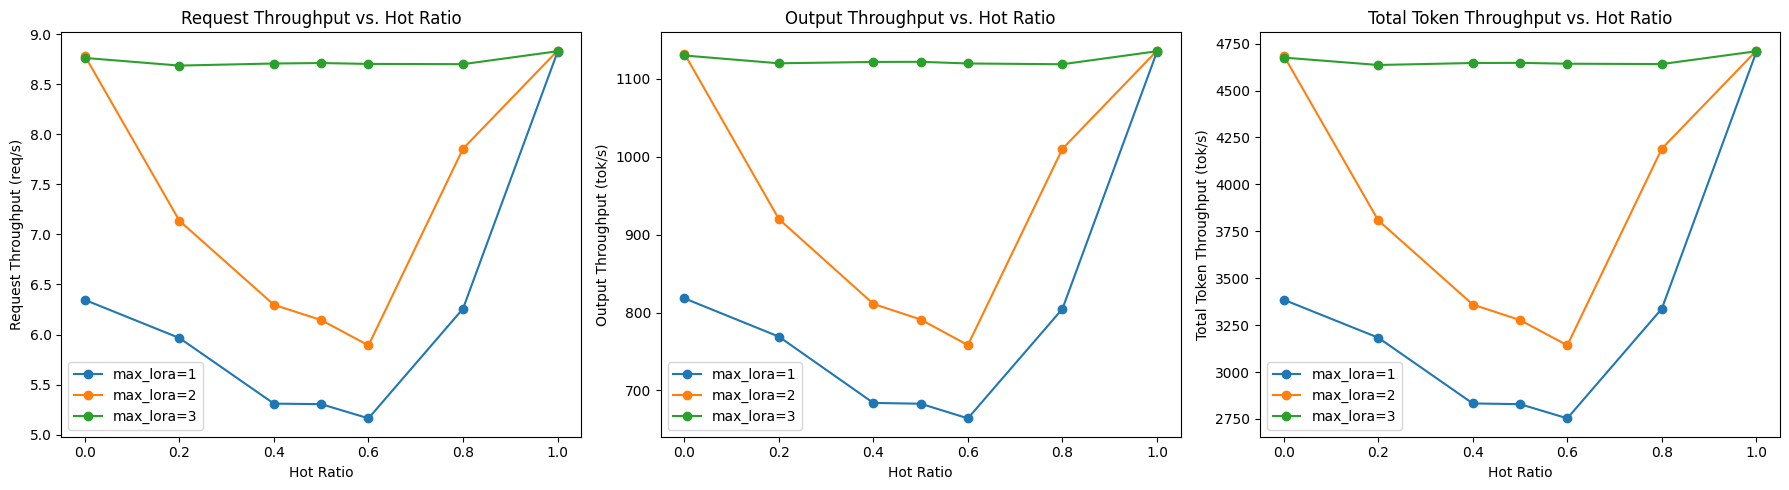

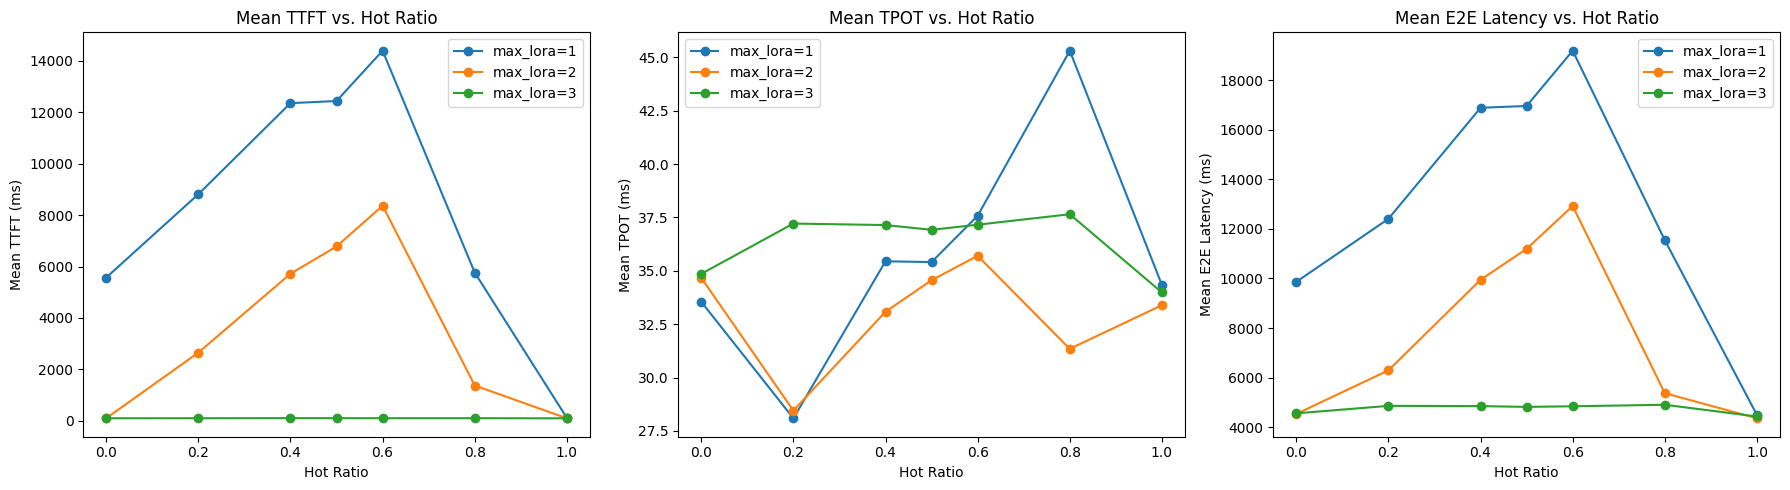

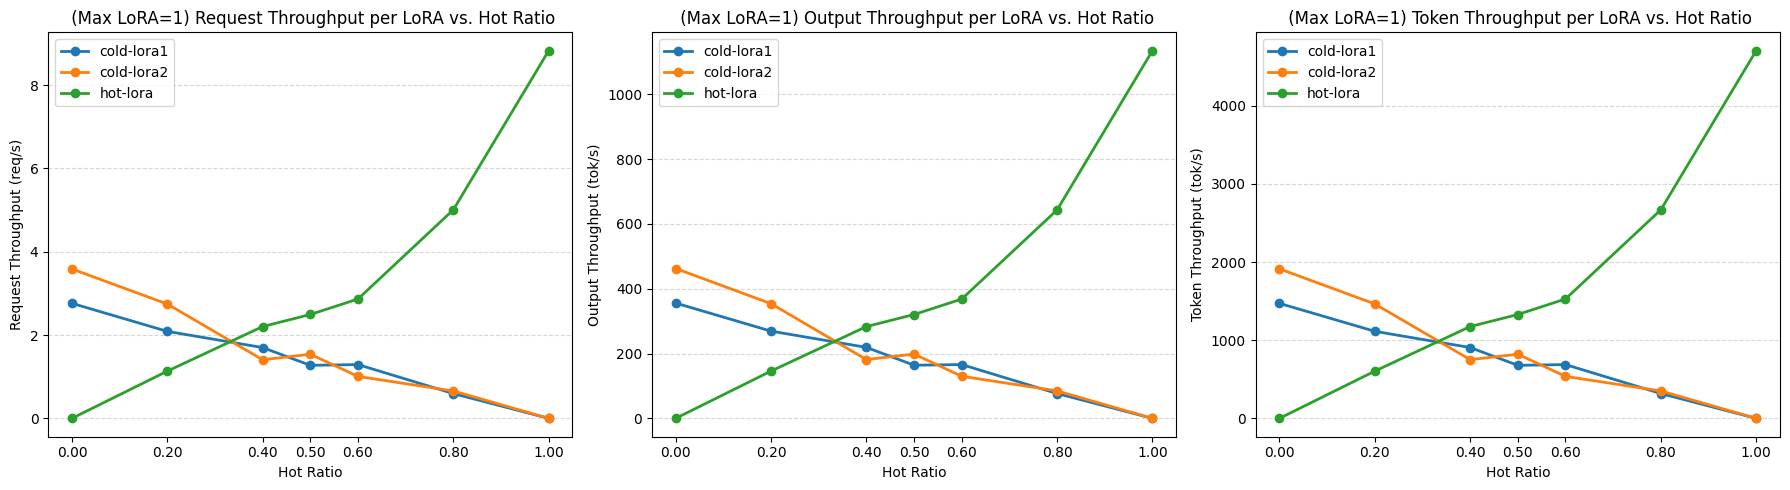

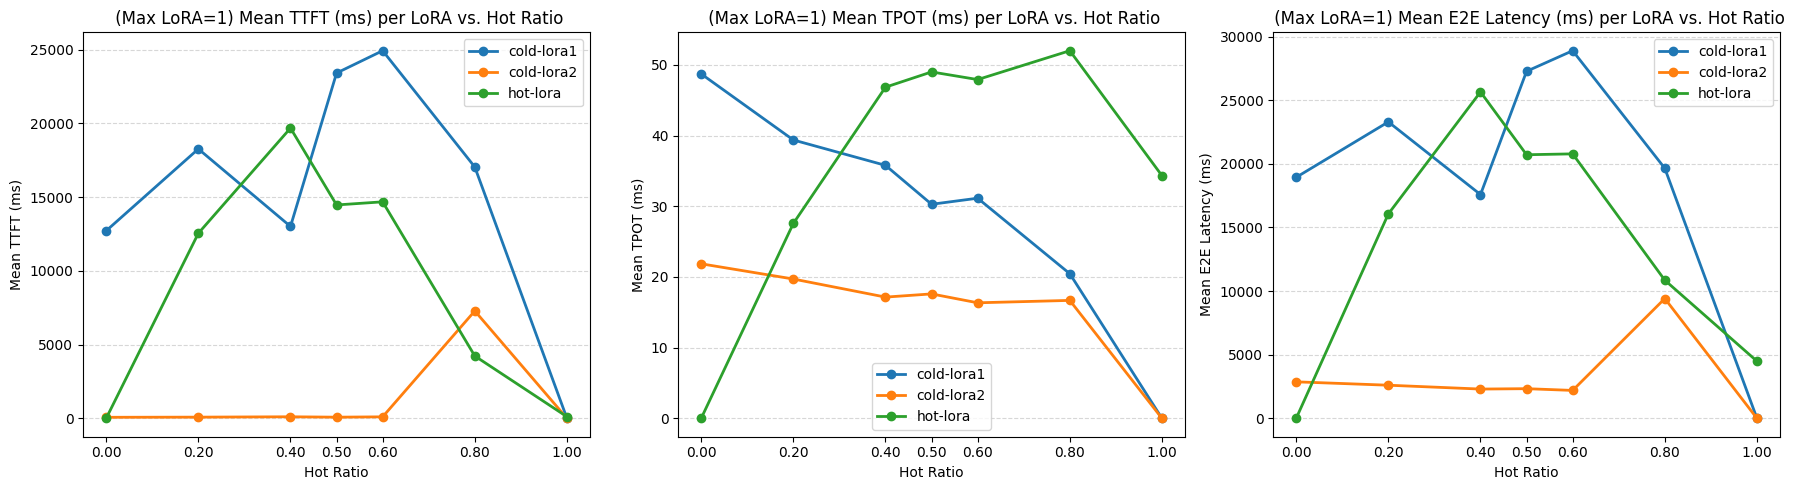

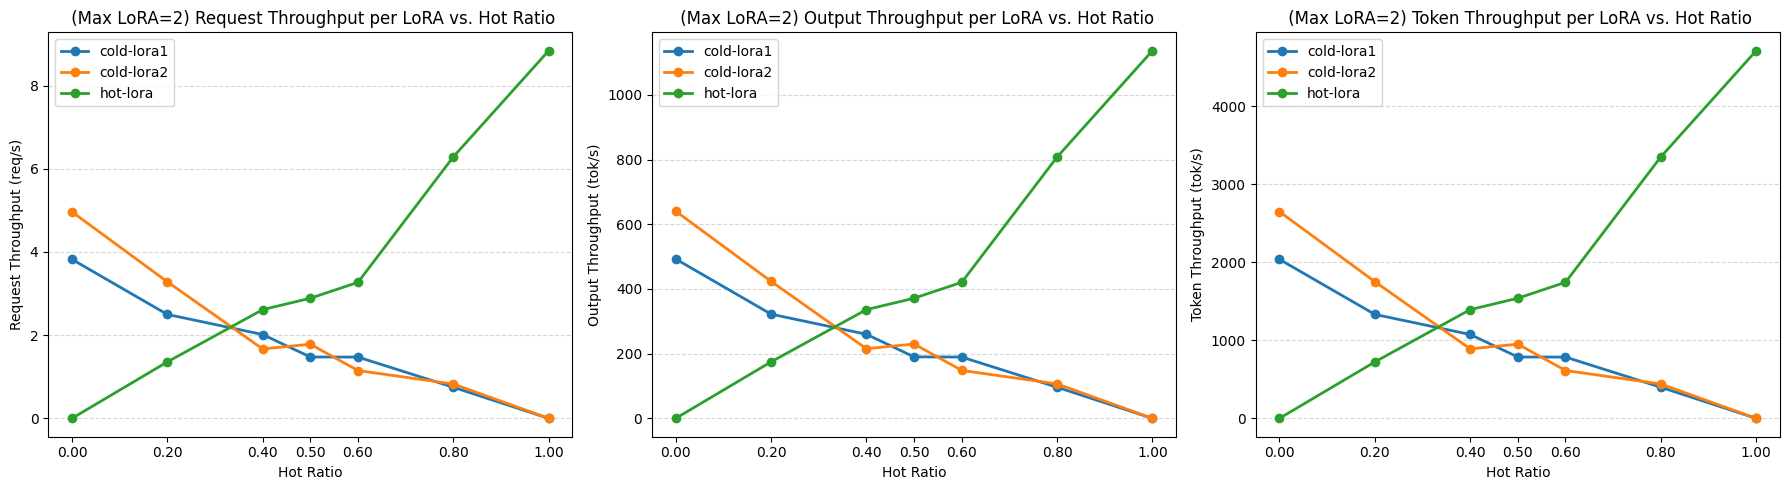

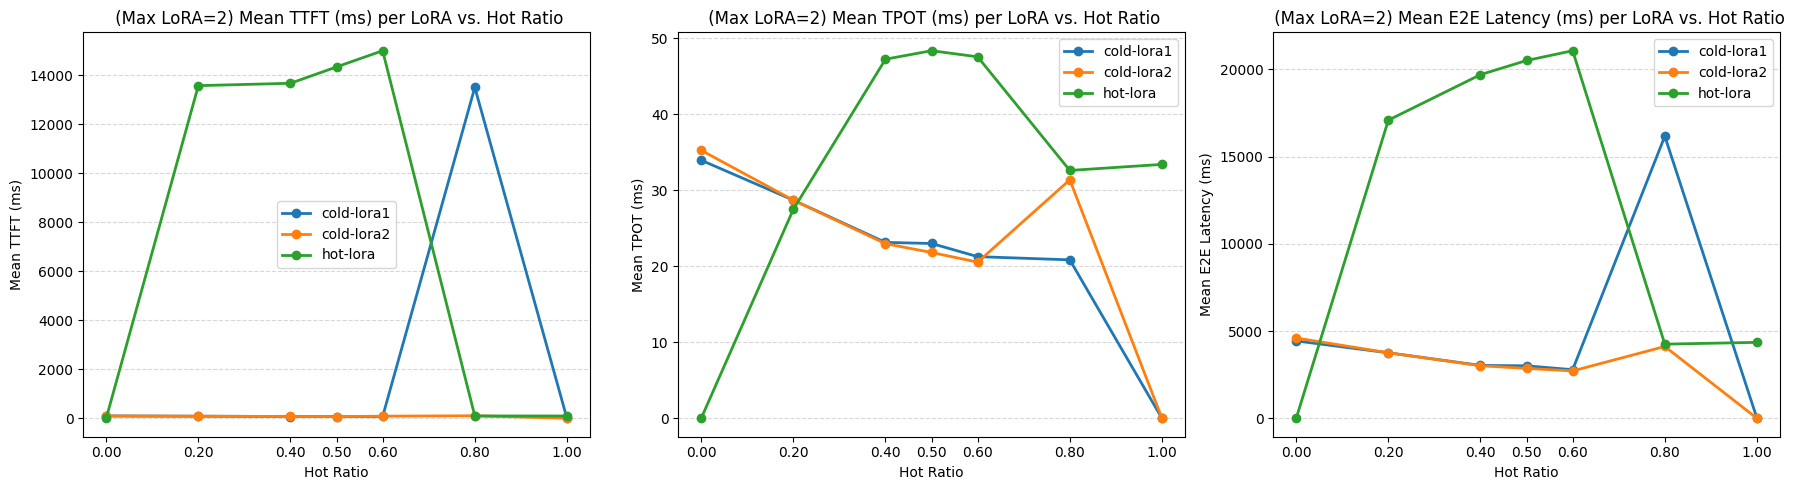

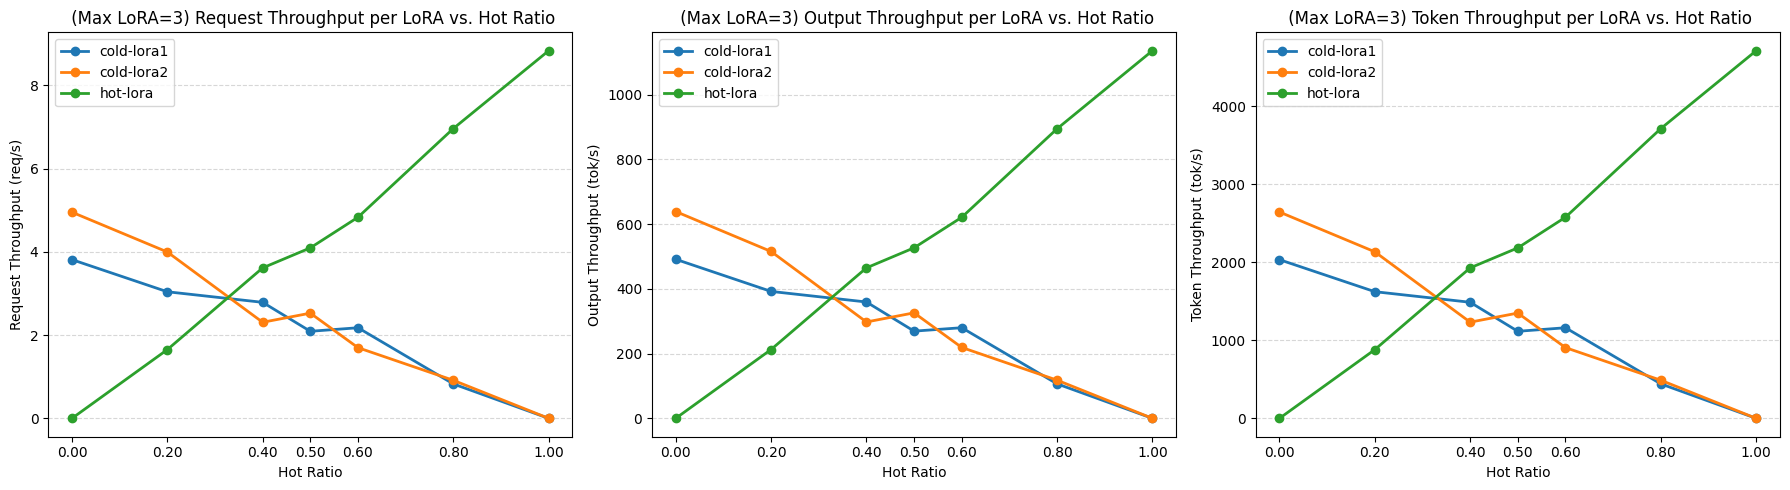

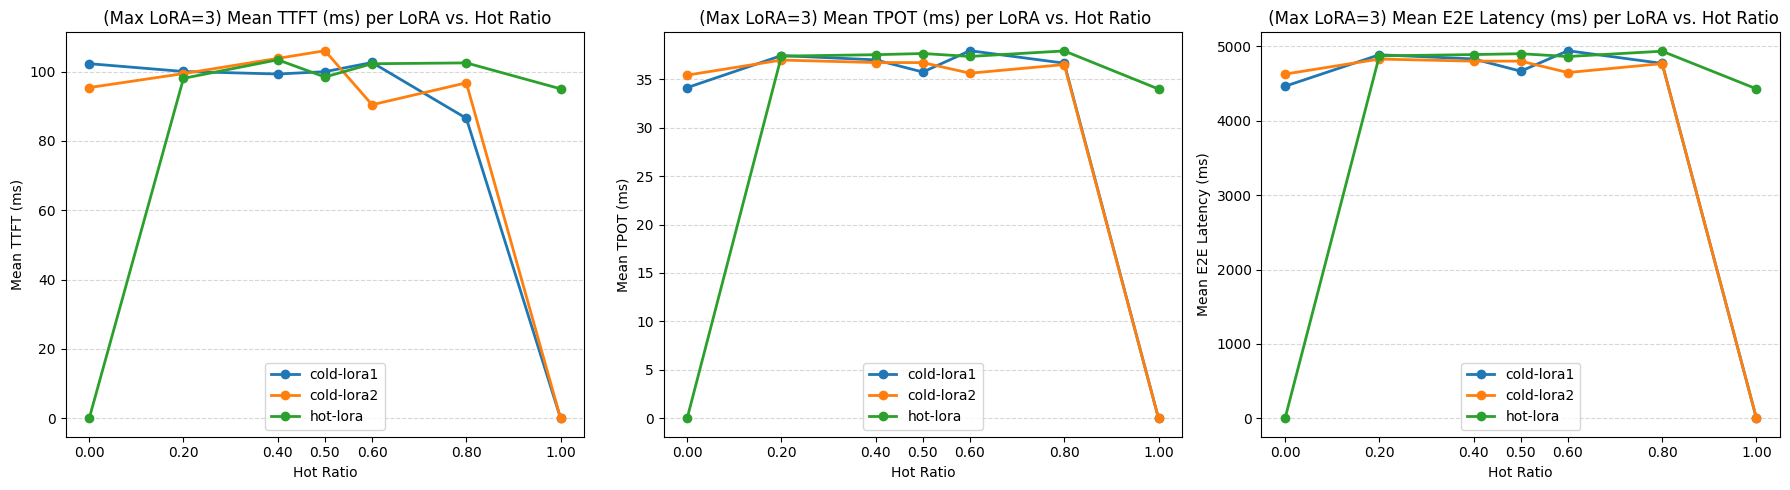

In [73]:
plot_all(baseline_df)

## Multi-LoRA

In [10]:
multi_lora_df = load_benchmark_results("multi_lora")
multi_lora_df.head()

,backend,base_model,tokenizer_id,num_prompts,request_rate,burstiness,max_concurrency,duration,completed,total_input_tokens,...,std_itl_ms,p99_itl_ms,mean_e2el_ms,median_e2el_ms,std_e2el_ms,p99_e2el_ms,per_lora_metrics,hot_ratio,max_lora,prefix
0,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,31.739179,200,80901,...,71.623603,174.723427,9882.061197,3044.307968,9024.424561,29251.915436,"{'cold-lora2': {'completed': 113, 'total_input...",0.0,1,multi_lora
1,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,29.237983,200,80934,...,21.191594,168.937617,8564.258615,3225.641683,8272.049536,27739.836634,"{'cold-lora2': {'completed': 92, 'total_input'...",0.2,1,multi_lora
2,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,28.354235,200,80945,...,19.313955,166.930395,7855.613696,3205.685571,7716.719207,27062.921166,"{'cold-lora2': {'completed': 53, 'total_input'...",0.4,1,multi_lora
3,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,27.223031,200,80915,...,18.026494,105.700703,6542.023960,3472.928753,6486.244821,25290.094701,"{'cold-lora2': {'completed': 58, 'total_input'...",0.5,1,multi_lora
4,vllm,baffo32/decapoda-research-llama-7B-hf,huggyllama/llama-7b,200,10.0,1.0,None,27.635494,200,80940,...,16.373556,76.060522,6826.928384,3371.616973,6816.309780,25722.403532,"{'cold-lora2': {'completed': 39, 'total_input'...",0.6,1,multi_lora


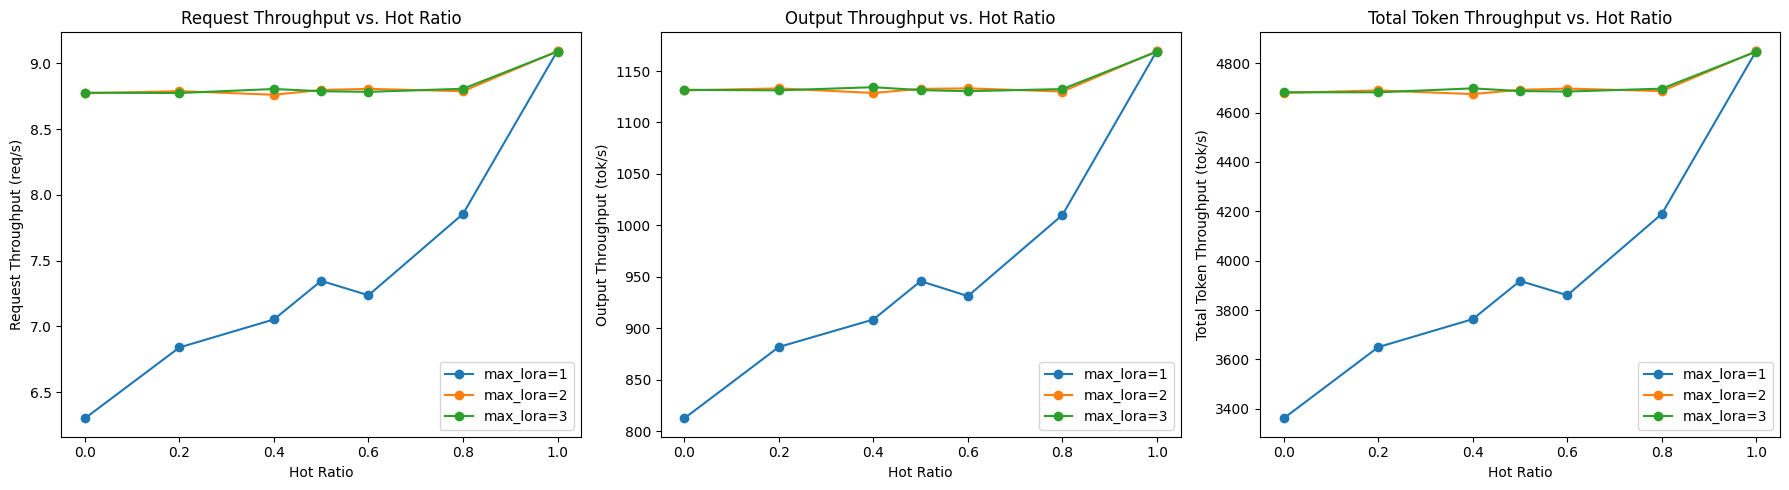

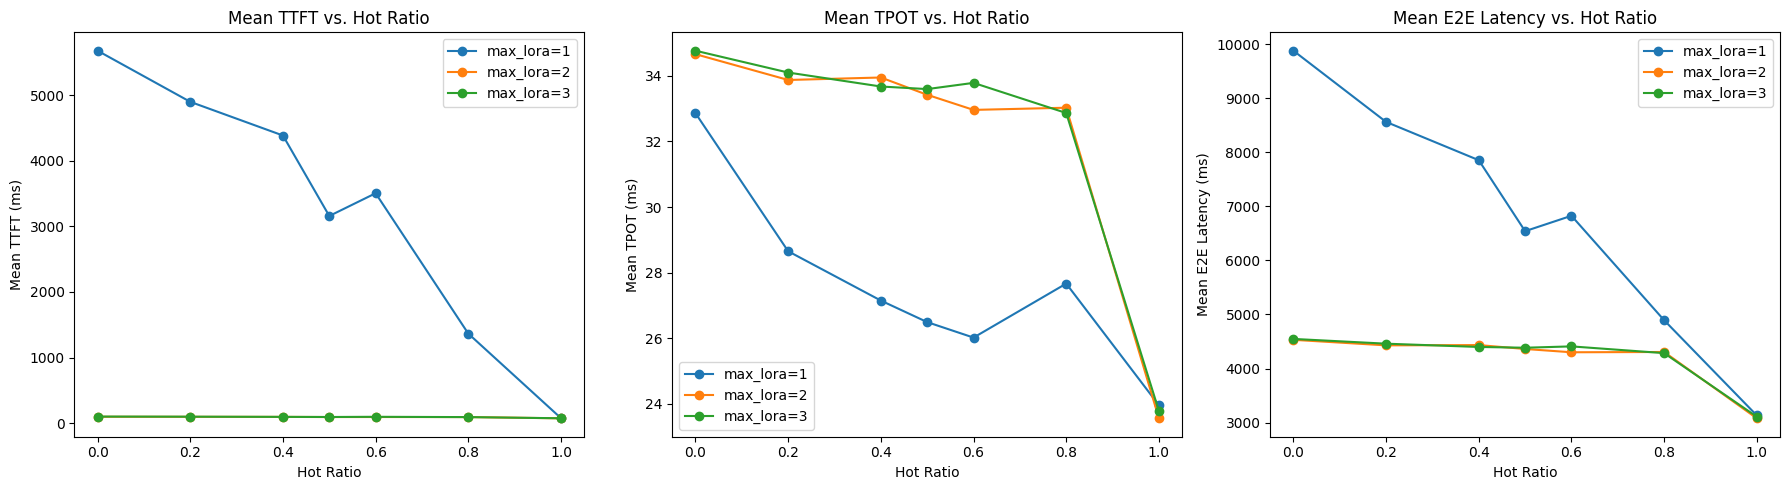

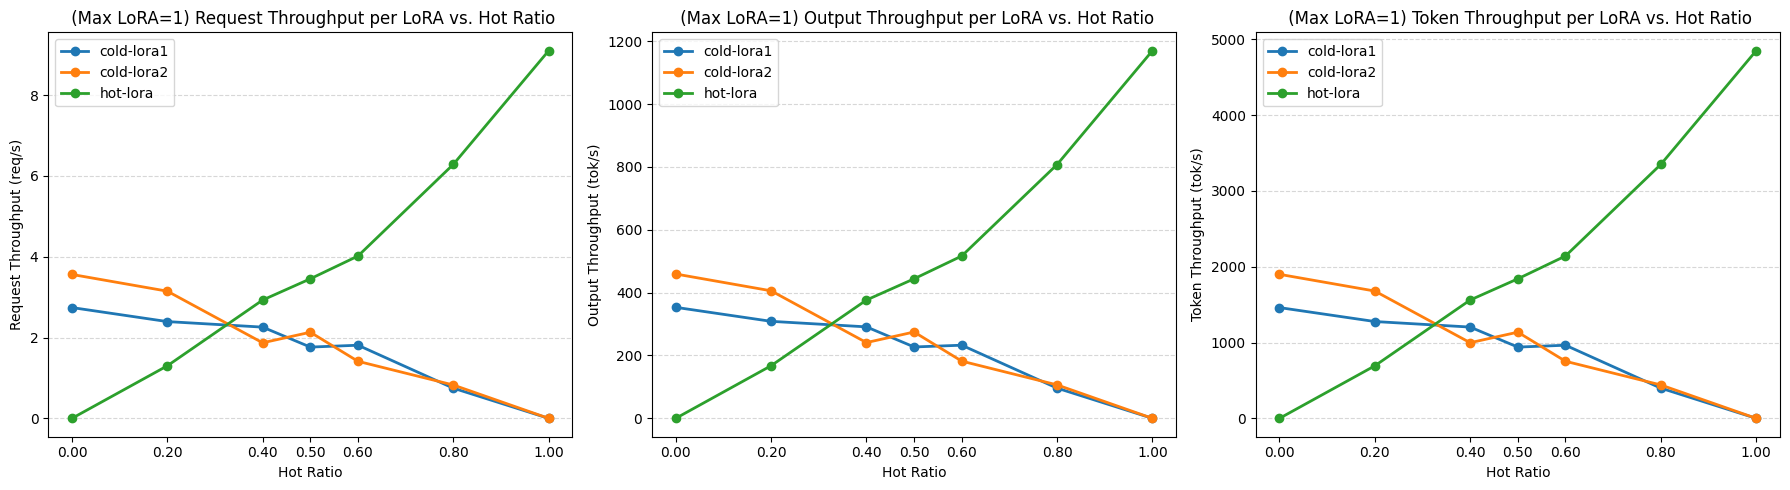

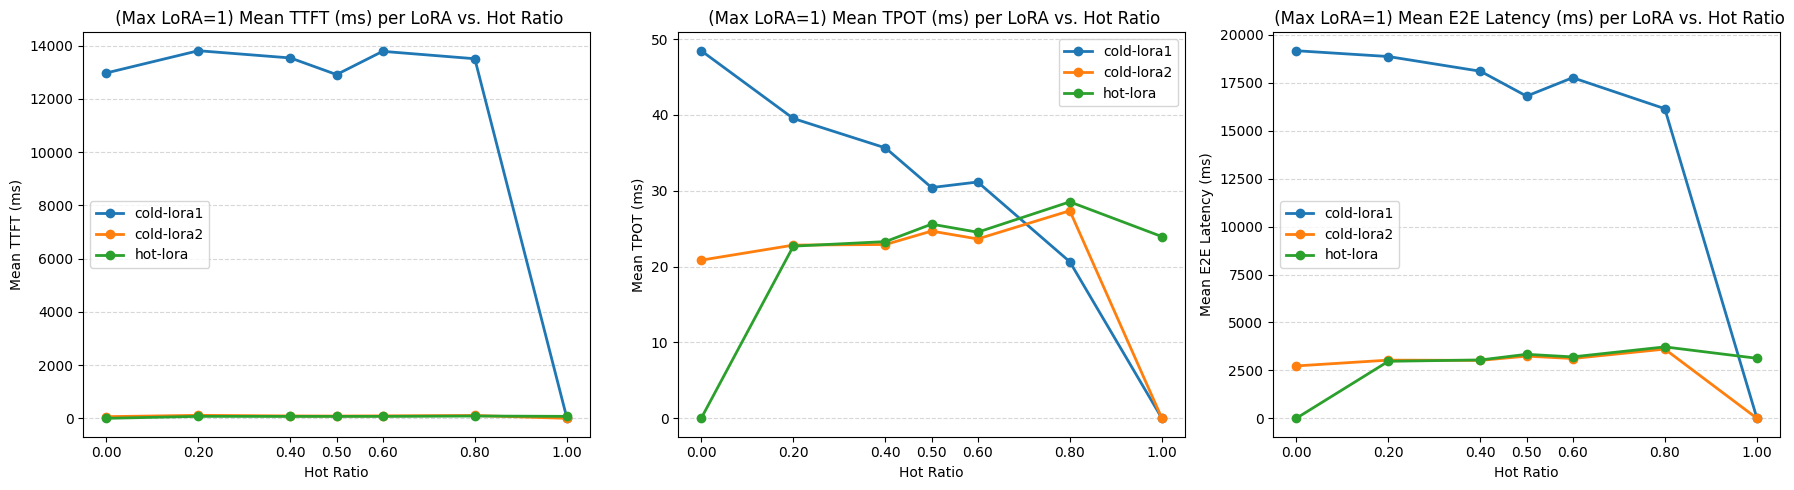

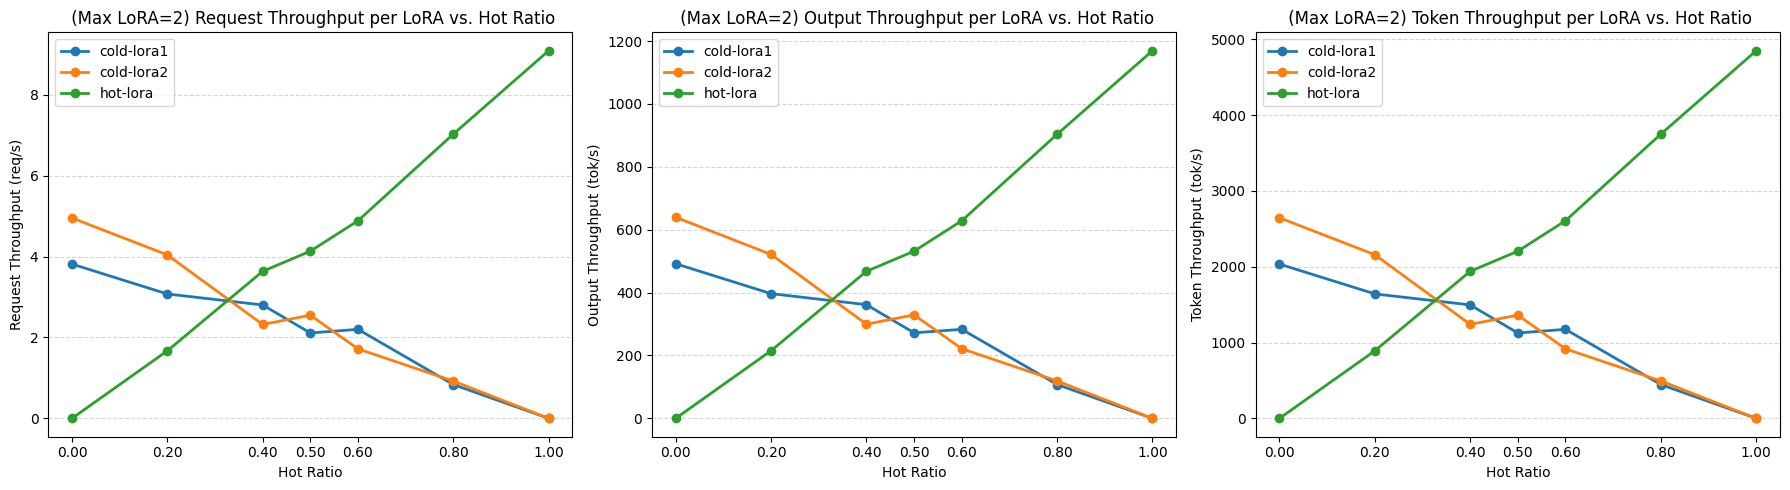

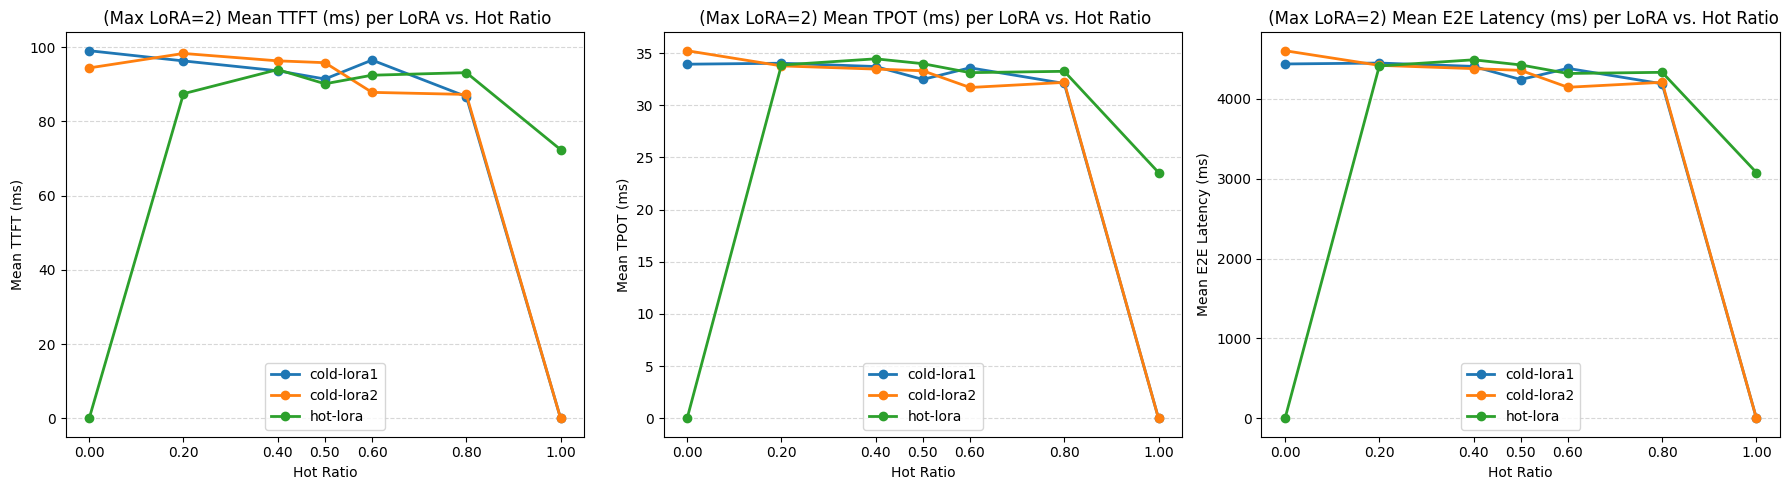

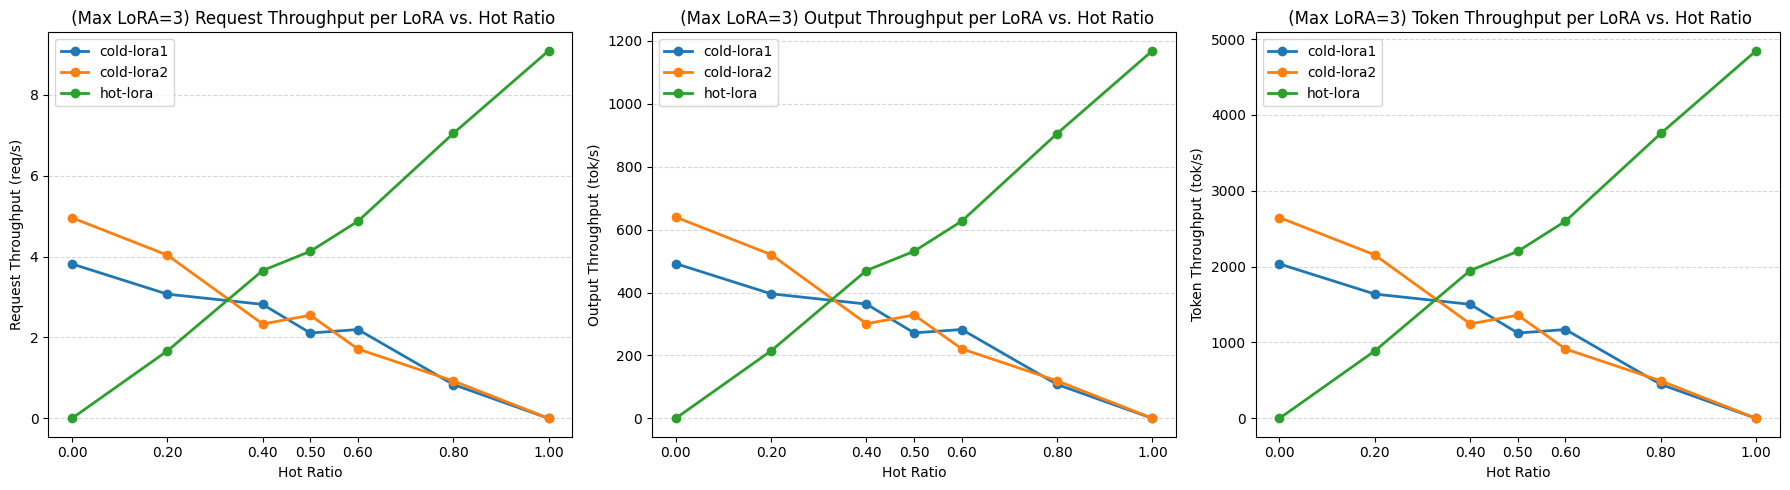

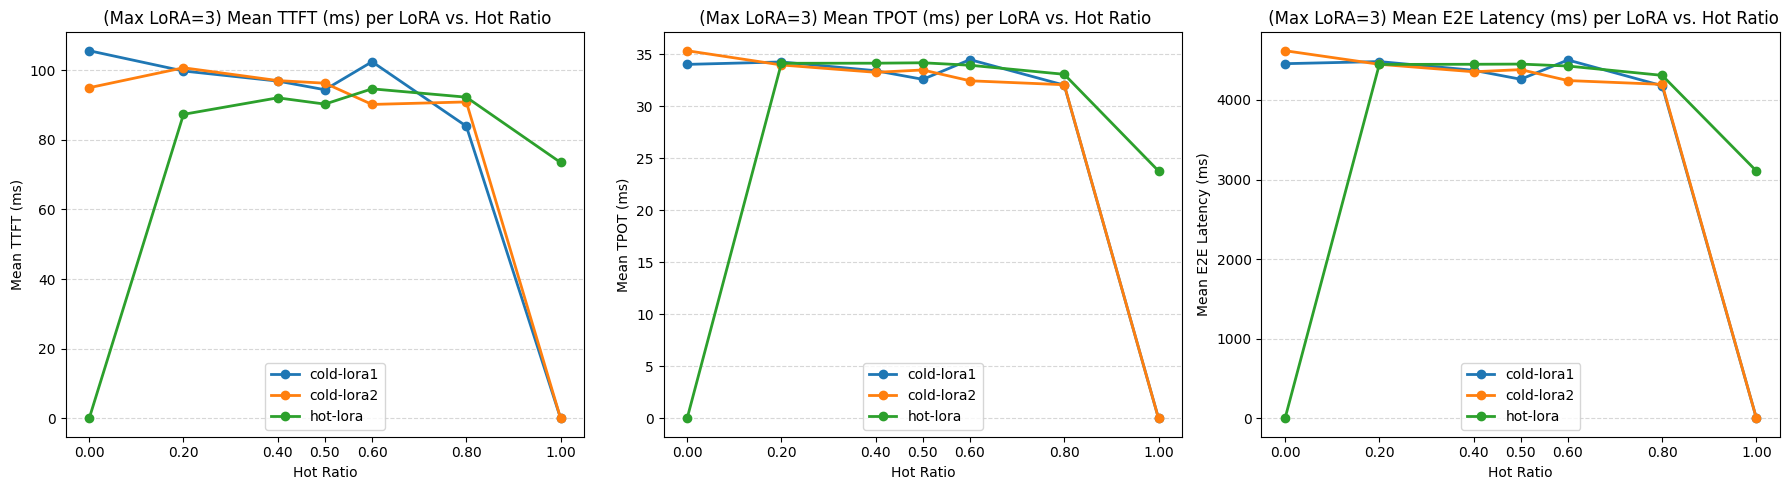

In [75]:
plot_all(multi_lora_df)

## Comparison

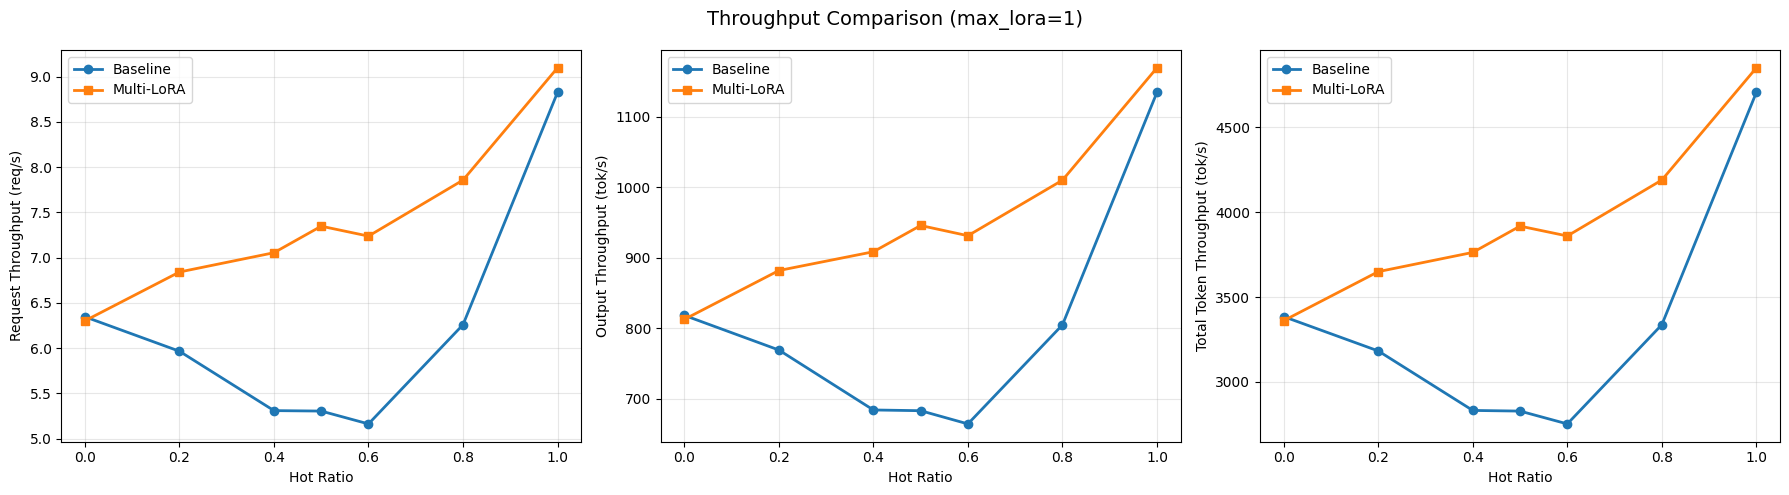

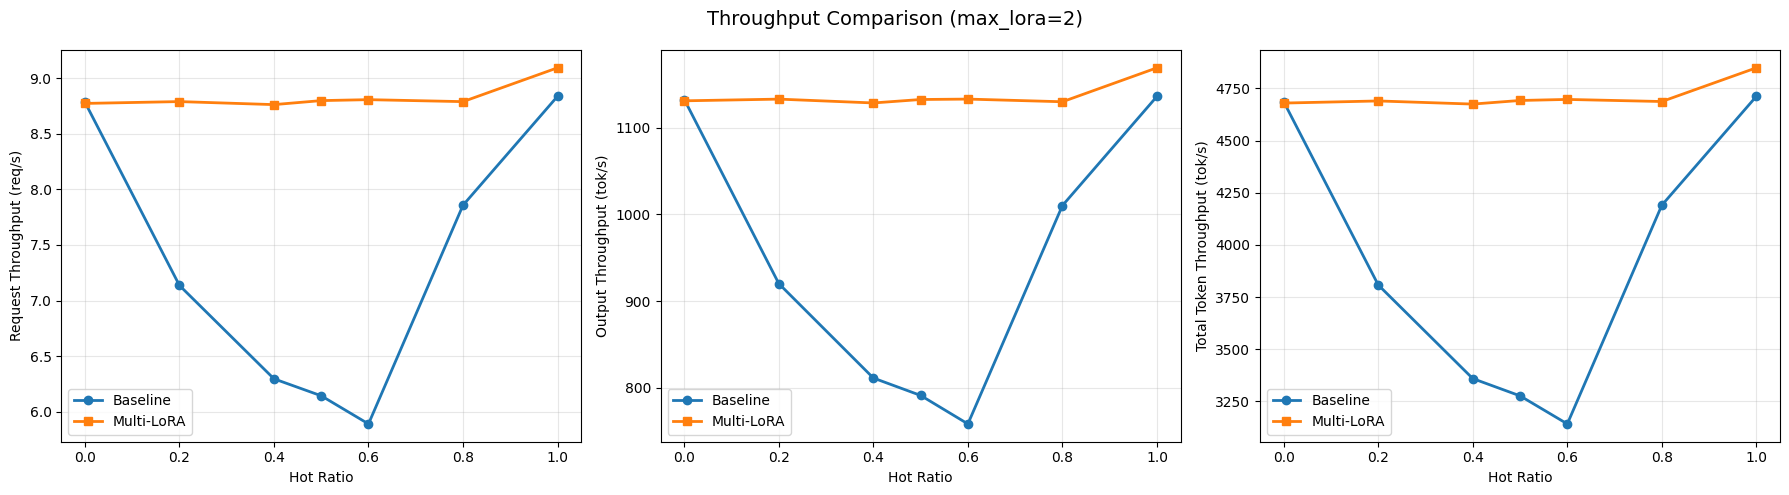

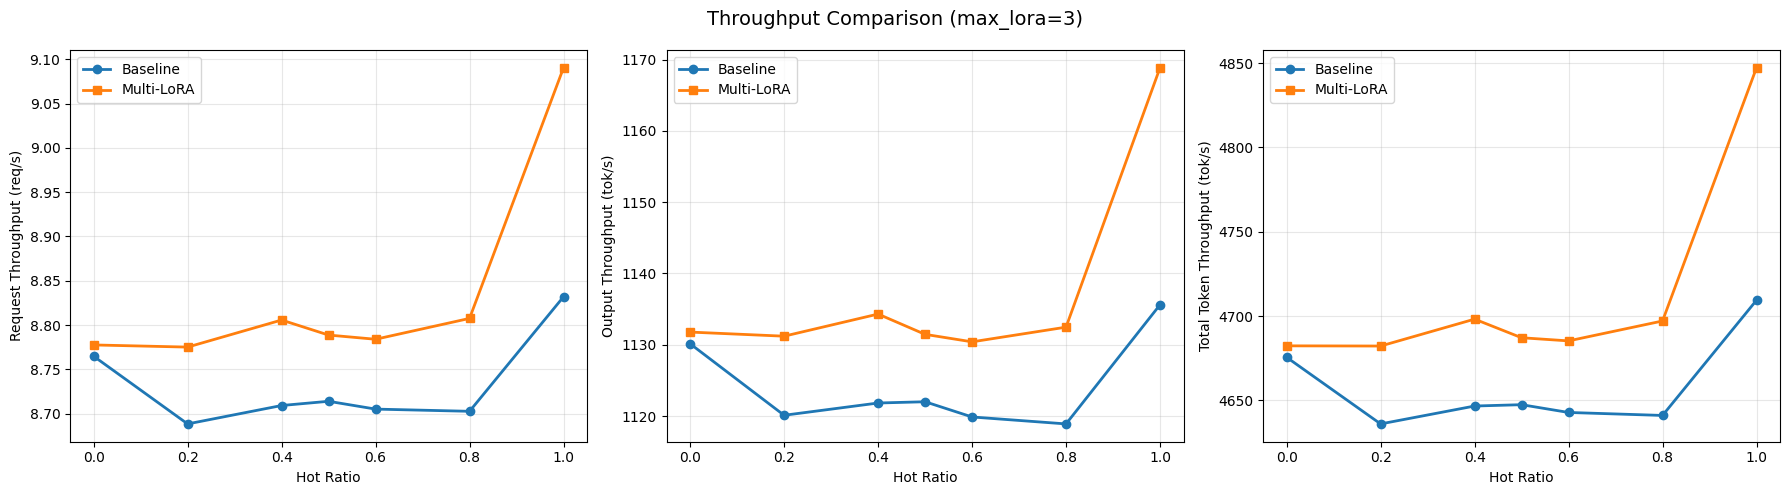

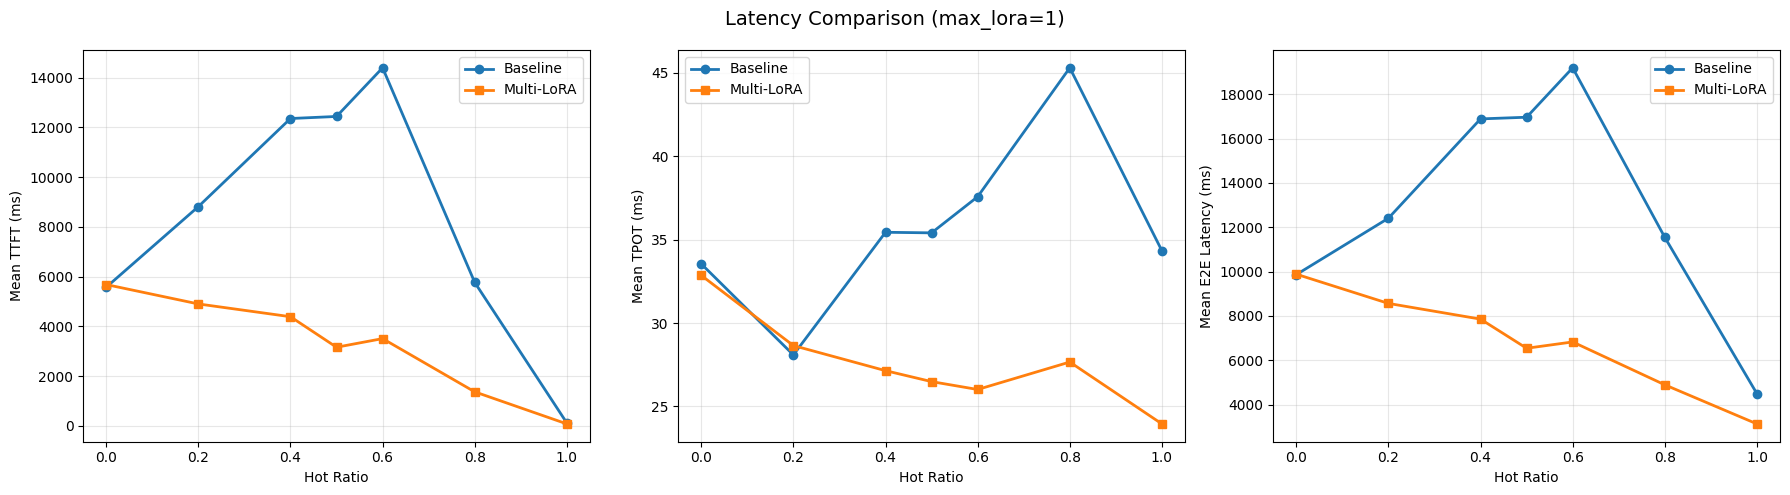

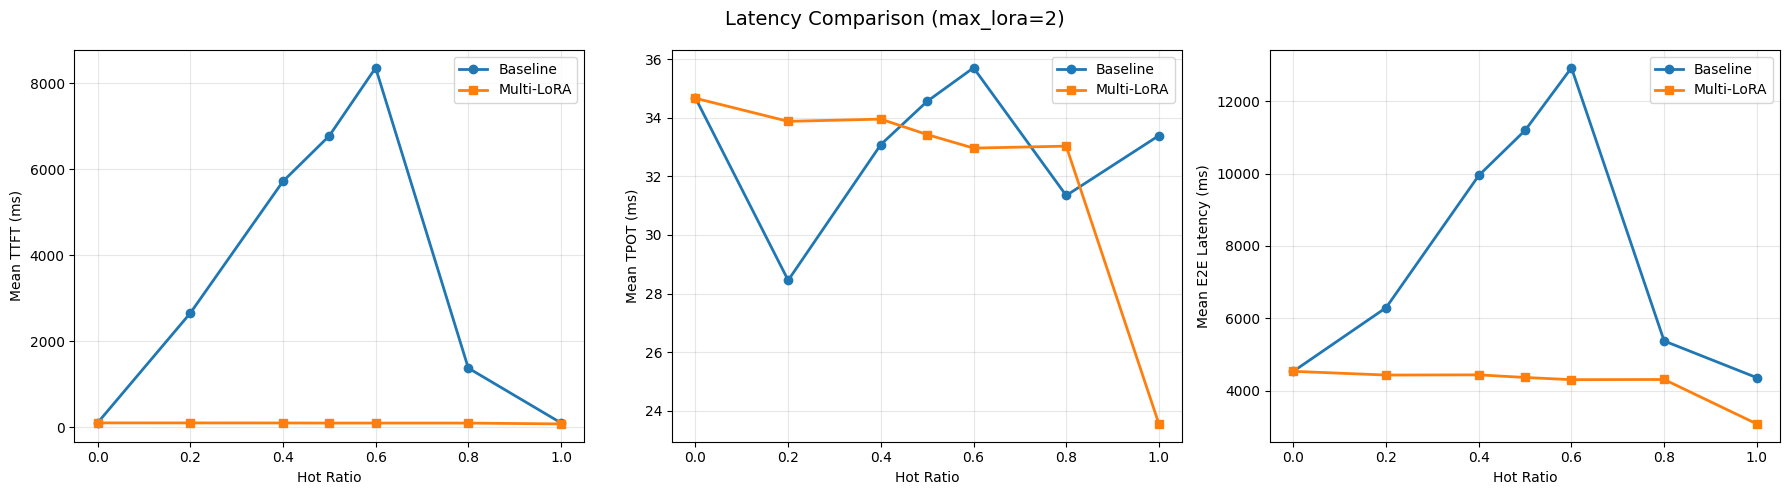

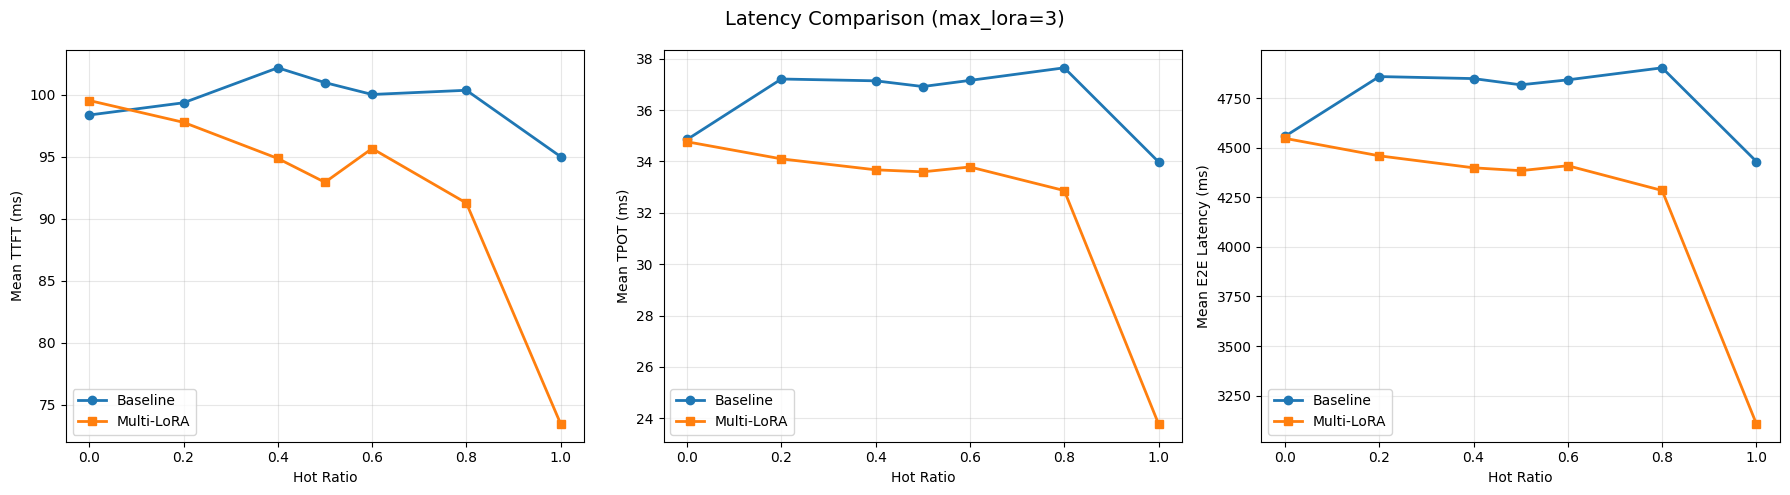

In [11]:
plot_full_comparison(baseline_df, multi_lora_df)

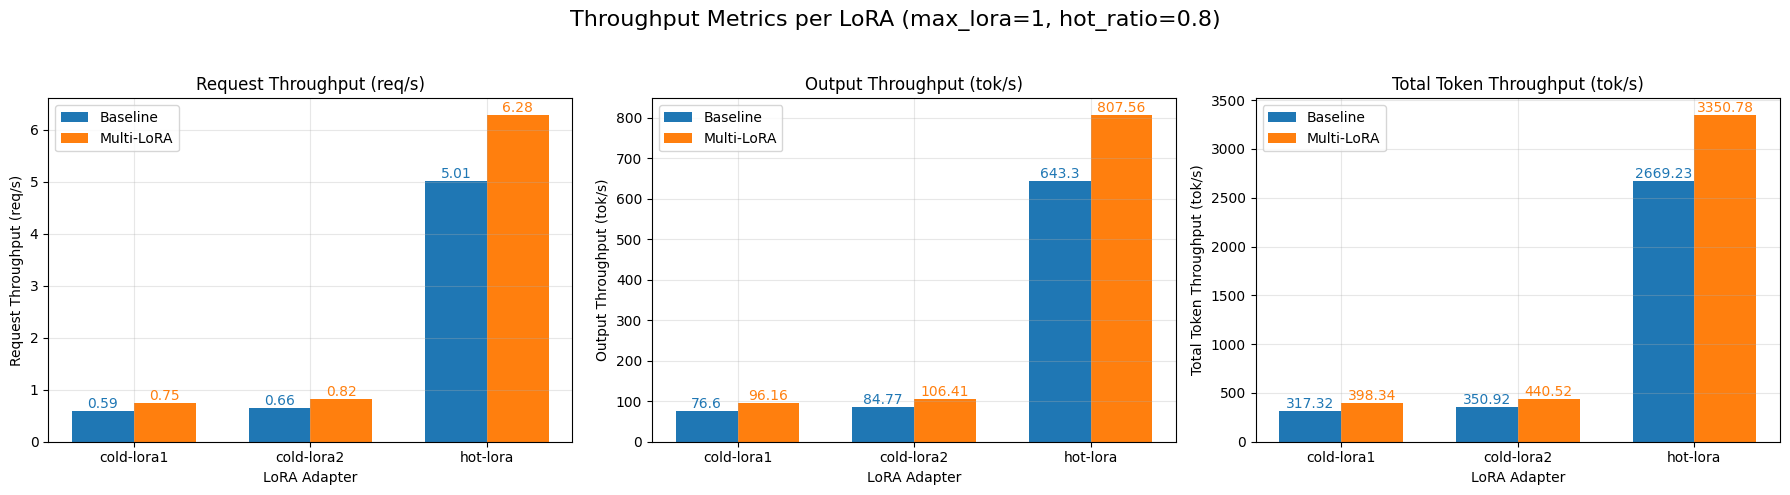

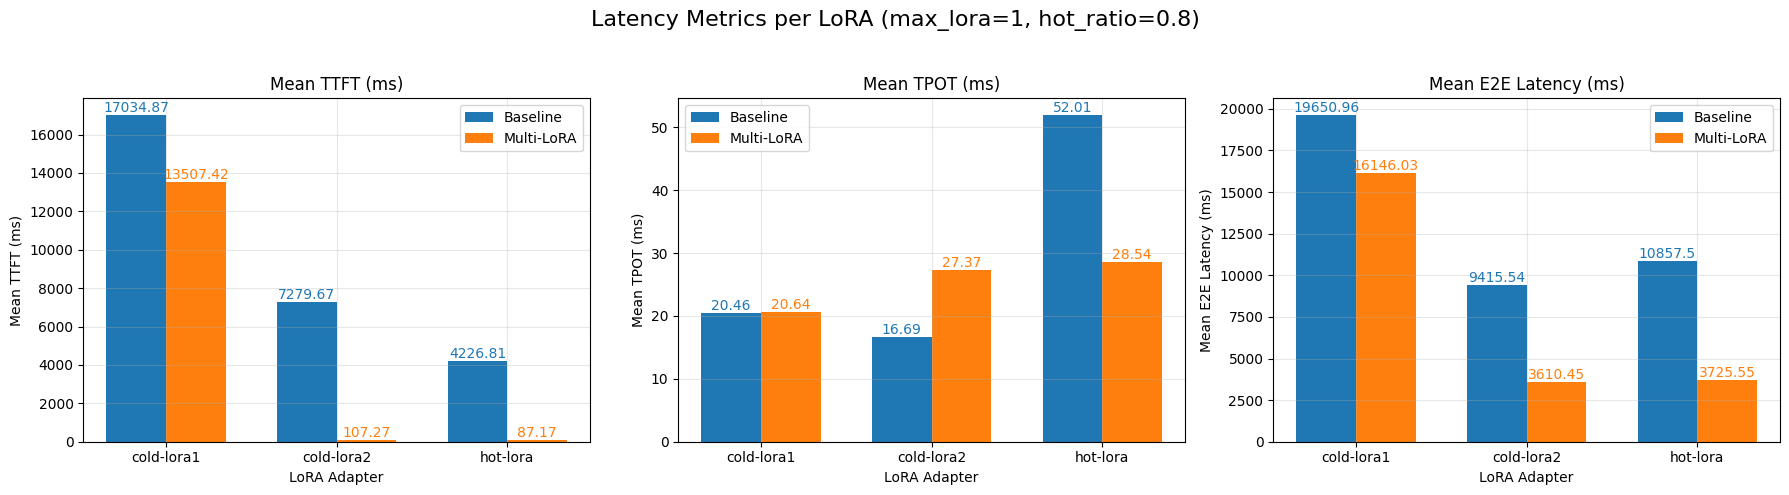

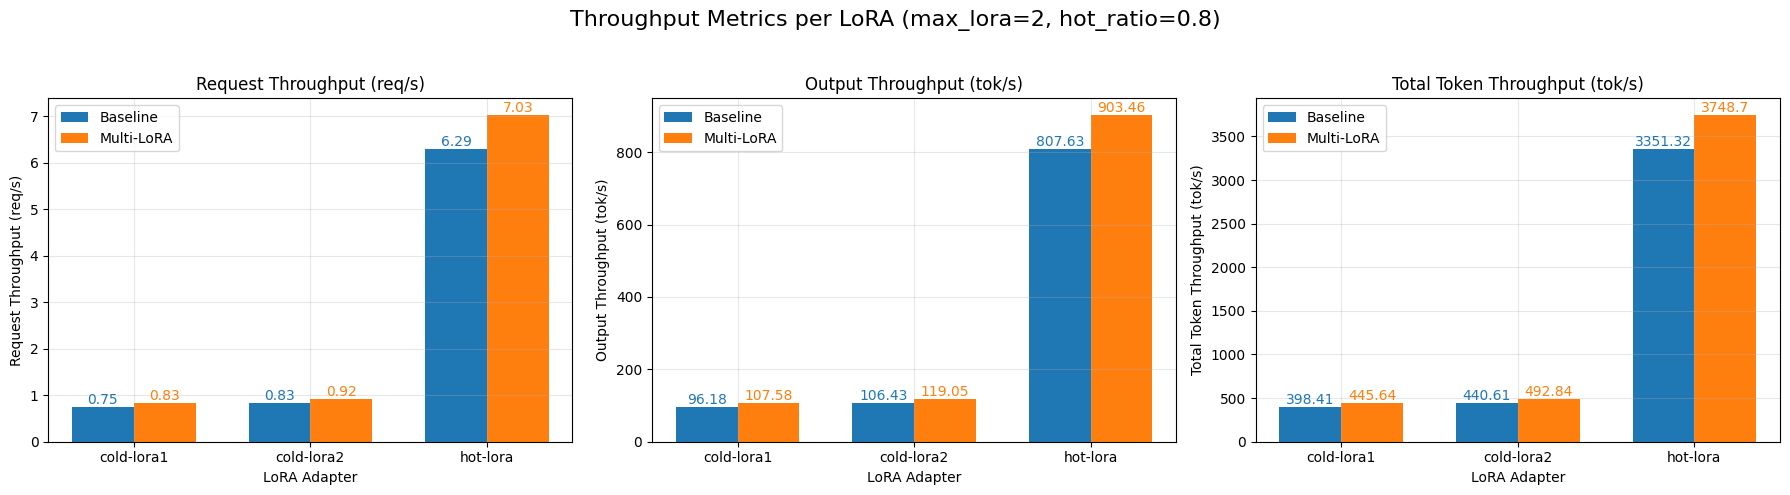

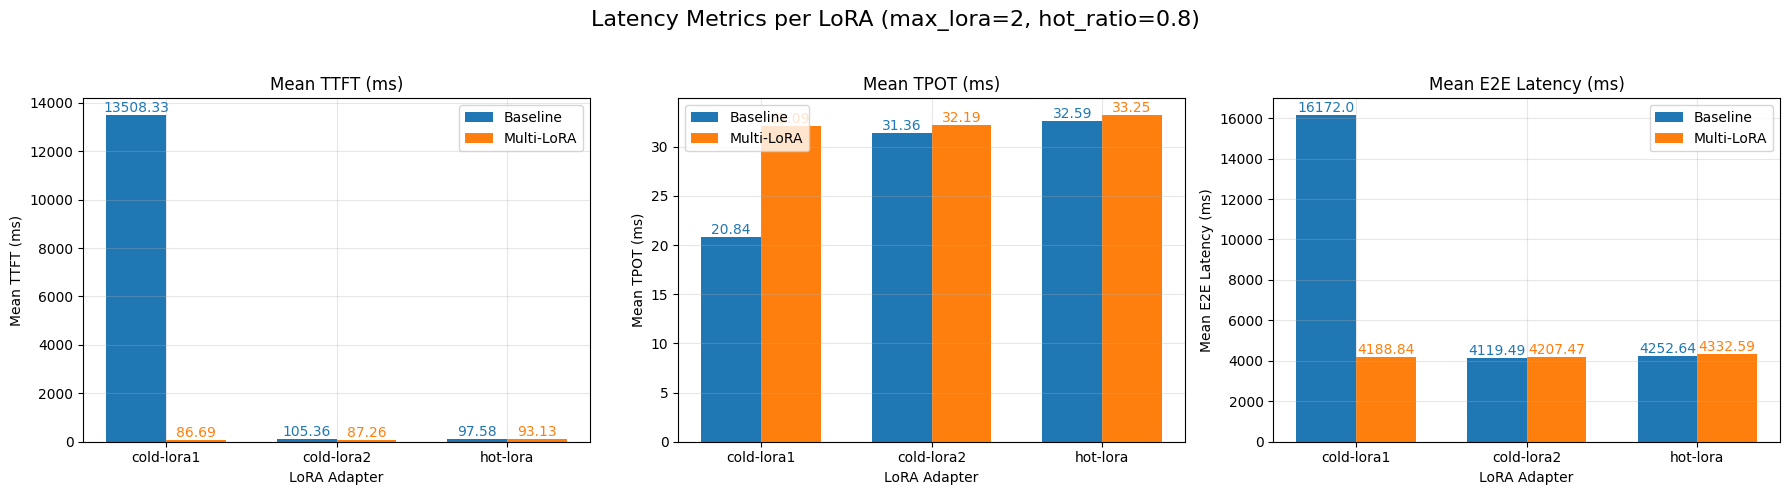

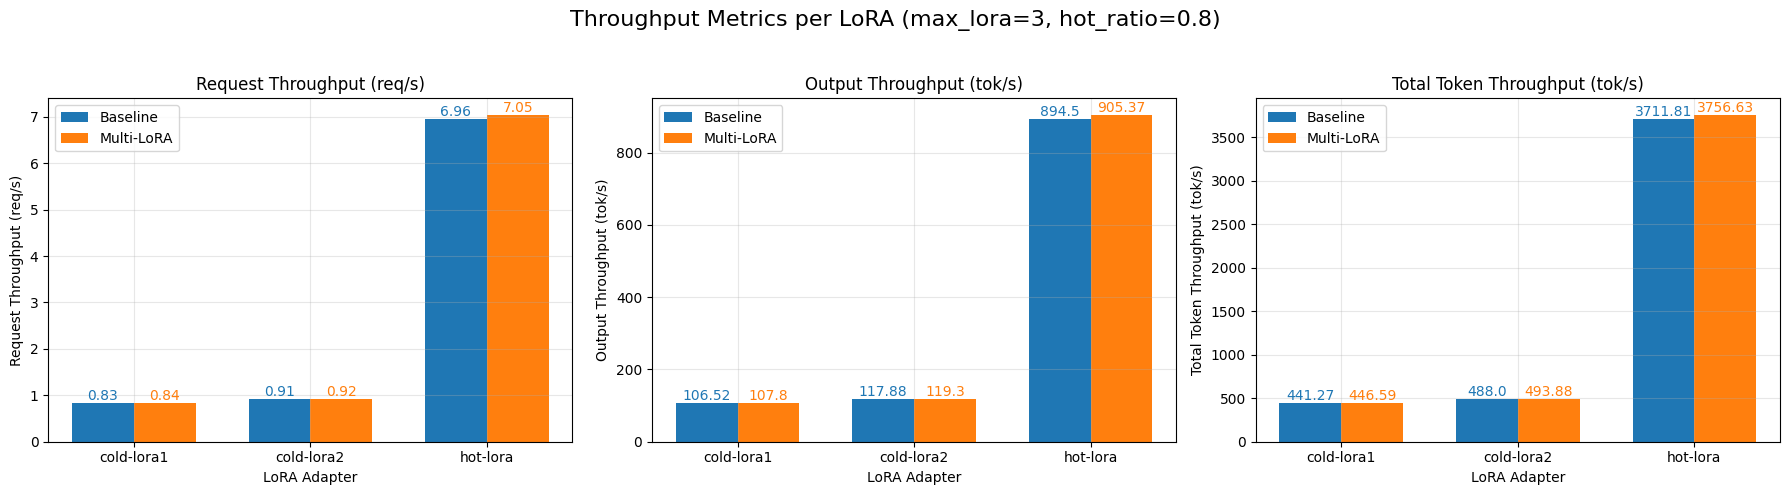

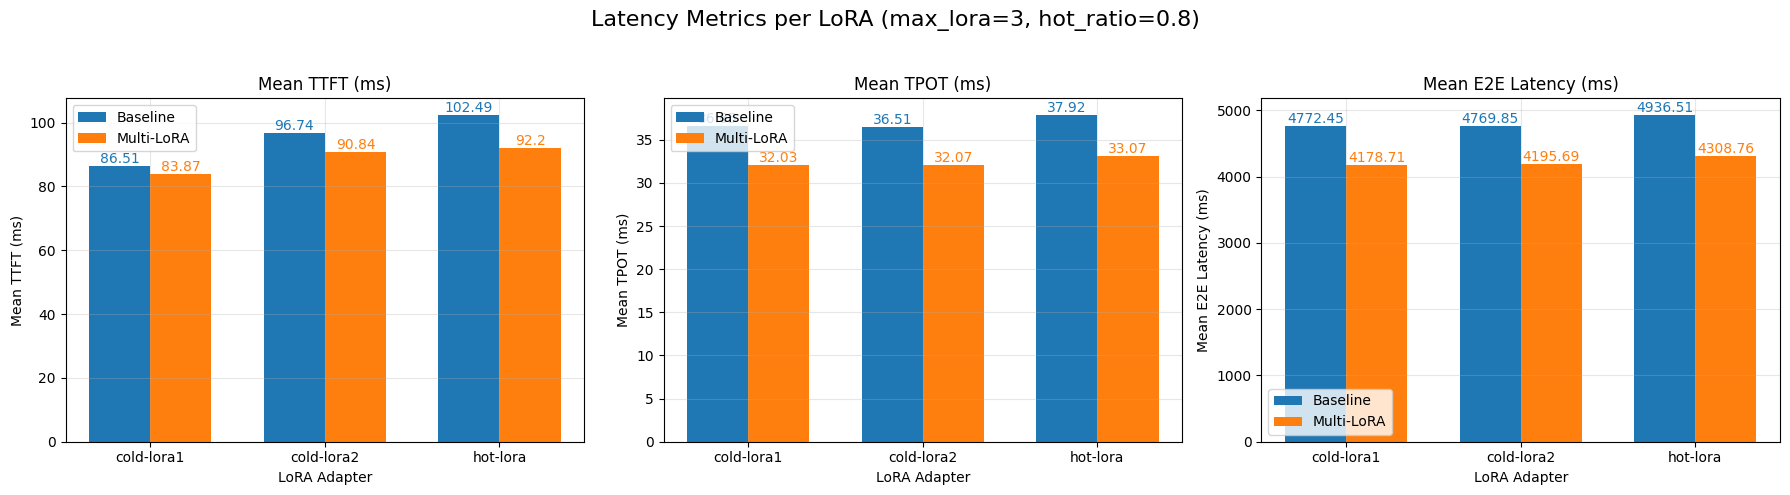

In [ ]:
plot_per_lora_comparison(baseline_df, multi_lora_df)